In [1]:
import numpy as np
import pandas as pd
from nltk import *
import json
from keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from keras.layers import *
from keras.initializers import Constant
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Model
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#import dataset
file = 'News_Category_Dataset.json'
data = pd.read_json(file, lines = True)
data.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [3]:
cats = data.groupby('category')
print(cats.ngroups)
print(cats.size())

31
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       3858
BUSINESS           4254
COLLEGE            1144
COMEDY             3971
CRIME              2893
EDUCATION          1004
ENTERTAINMENT     14257
FIFTY              1401
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
IMPACT             2602
LATINO VOICES      1129
MEDIA              2815
PARENTS            3955
POLITICS          32739
QUEER VOICES       4995
RELIGION           2556
SCIENCE            1381
SPORTS             4167
STYLE              2254
TASTE              2096
TECH               1231
THE WORLDPOST      3664
TRAVEL             2145
WEIRD NEWS         2670
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          2579
dtype: int64


In [4]:
# We see that the categories 'THE WORLDPOST' and 'WORLDPOST' are the same. We need to combine them.
data.category = data.category.map(lambda x: 'WORLDPOST' if x =='THE WORLDPOST' else x)

In [5]:
# Construct a 'text' column in the dataframe that contains the headline and short descriptions
data['text'] = data.headline + ' ' + data.short_description

In [6]:
# We tokenize the text, write them into a new 'words' column.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)

T = tokenizer.texts_to_sequences(data.text)
data['words'] = T

In [7]:
# We neglect the entries with a short text.
data['word_length'] = data.words.apply(lambda x: len(x))
data = data[data.word_length>=5]
data.word_length.describe()

count    124068.000000
mean         26.128422
std          14.366390
min           5.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         248.000000
Name: word_length, dtype: float64

In [8]:
# We index the categories
catergories = data.groupby('category').size().index.tolist()

cat_to_int = {}
int_to_cat = {}
for i, k in enumerate(catergories):
    cat_to_int.update({k:i})
    int_to_cat.update({i:k})
    
data['cat_id'] = data['category'].apply(lambda x: cat_to_int[x])

/Users/Xuntao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
# We now upload the GloVe model (100D version). Getting ready for word embedding.

EMBEDDING_DIM = 100
embedding_index = {}
f = open('/Users/Xuntao/DataScience/glove.6B.100d.txt')

for line in f:
    vector = line.split()
    word = vector[0]
    coefs = np.asarray(vector[1:], dtype = 'float32')
    embedding_index[word] = coefs
    
f.close()

In [10]:
# Construct the embedding matrix

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
# Construct a layer that embeds all the text using the embedding matrix above.
maxlen = 50
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [12]:
# Prepare Data

X = list(sequence.pad_sequences(data.words, maxlen = maxlen))
X = np.array(X)
Y = np_utils.to_categorical(list(data.cat_id))

# Split the training and validating sets

X_train, X_val, Y_train, Y_val = tts(X,Y, test_size = 0.2, random_state = 29)

In [13]:
print(len(X_train),len(X_val), len(data))

99254 24814 124068


In [14]:
#construct text CNN
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(catergories), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      8662800     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       12864       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 64)       19264       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [ ]:
textcnn_history = TextCNN.fit(X_train, 
                              Y_train, 
                              batch_size=128, 
                              epochs=10, 
                              validation_data=(X_val, Y_val))

Train on 99254 samples, validate on 24814 samples
Epoch 1/10
99254/99254 [==============================] - 74s 747us/step - loss: 2.1990 - acc: 0.4096 - val_loss: 1.7270 - val_acc: 0.5126
Epoch 2/10
99254/99254 [==============================] - 70s 700us/step - loss: 1.8211 - acc: 0.4937 - val_loss: 1.6109 - val_acc: 0.5494
Epoch 3/10
99254/99254 [==============================] - 62s 628us/step - loss: 1.7370 - acc: 0.5156 - val_loss: 1.5683 - val_acc: 0.5587
Epoch 4/10
99254/99254 [==============================] - 63s 633us/step - loss: 1.6901 - acc: 0.5264 - val_loss: 1.5341 - val_acc: 0.5708
Epoch 5/10
99254/99254 [==============================] - 63s 633us/step - loss: 1.6633 - acc: 0.5342 - val_loss: 1.5220 - val_acc: 0.5701
Epoch 6/10
99254/99254 [==============================] - 64s 645us/step - loss: 1.6444 - acc: 0.5387 - val_loss: 1.5150 - val_acc: 0.5720
Epoch 7/10
99254/99254 [==============================] - 65s 659us/step - loss: 1.6281 - acc: 0.5434 - val_loss: 1.

In [55]:
#Train with bidirectional GRU. 

inp2 = Input(shape = (maxlen,), dtype = 'int32')
x = embedding_layer(inp2)

x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences = True, dropout=0.2, recurrent_dropout = 0.2))(x)
x = Conv1D(64, kernel_size = 3)(x)
avg_pooling = GlobalAveragePooling1D()(x)
max_pooling = GlobalMaxPooling1D()(x)

x = concatenate([avg_pooling, max_pooling])
x = Dropout(0.2)(x)
output2 = Dense(len(catergories), activation = 'softmax')(x)

BiGRU = Model(inp2, output2)
BiGRU.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

BiGRU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      8662800     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 50, 100)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 50, 256)      175872      spatial_dropout1d_4[0][0]        
__________________________________________________________________________________________________
conv1d_4 (

In [57]:
BiGRU_history = BiGRU.fit(X_train, Y_train,
                         batch_size = 128,
                         epochs = 15,
                         validation_data=(X_val, Y_val))

Train on 99254 samples, validate on 24814 samples
Epoch 1/15
99254/99254 [==============================] - 263s 3ms/step - loss: 1.6863 - acc: 0.5248 - val_loss: 1.4560 - val_acc: 0.5818
Epoch 2/15
99254/99254 [==============================] - 269s 3ms/step - loss: 1.5683 - acc: 0.5541 - val_loss: 1.4017 - val_acc: 0.5951
Epoch 3/15
99254/99254 [==============================] - 267s 3ms/step - loss: 1.5091 - acc: 0.5690 - val_loss: 1.3517 - val_acc: 0.6068
Epoch 4/15
99254/99254 [==============================] - 260s 3ms/step - loss: 1.4699 - acc: 0.5782 - val_loss: 1.3415 - val_acc: 0.6069
Epoch 5/15
99254/99254 [==============================] - 265s 3ms/step - loss: 1.4365 - acc: 0.5860 - val_loss: 1.3171 - val_acc: 0.6154
Epoch 6/15
99254/99254 [==============================] - 264s 3ms/step - loss: 1.4096 - acc: 0.5917 - val_loss: 1.2995 - val_acc: 0.6186
Epoch 7/15
99254/99254 [==============================] - 263s 3ms/step - loss: 1.3875 - acc: 0.5973 - val_loss: 1.2904 - 

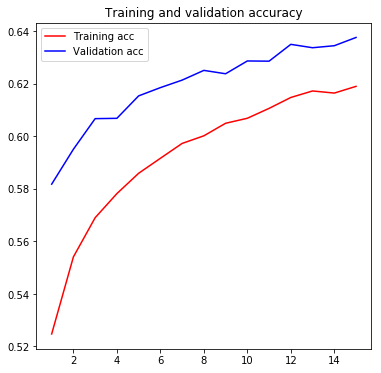

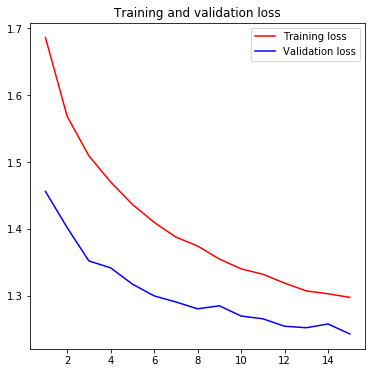

In [60]:
#Plot the GRU
def train_val_ploting(my_history):
    plt.rcParams['figure.figsize'] = (6,6)

    plt.rcParams['figure.figsize'] = (6,6)

    acc = my_history.history['acc']
    val_acc = my_history.history['val_acc']
    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()

    plt.show()